In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from snorkel import SnorkelSession
session = SnorkelSession()
from snorkel.models import  Document, Sentence

In [9]:
from snorkel.lf_helpers import *
import pickle,glob

In [4]:
from snorkel.models import Candidate, candidate_subclass
REGULATOR = candidate_subclass('REGULATOR', ['Chemical', 'Gene'])

In [5]:
# make sure unmapped cands are gone

In [6]:
from sqlalchemy import  any_,or_,and_

In [7]:
#create list of unmapped cands to drop
to_drop = []
for k in range(3):
    query = session.query(REGULATOR).filter(and_(REGULATOR.split==k,~REGULATOR.gold_labels.any()))
    print 'Adding %i candidates from split=%i in to_drop list'%(query.count(), k)
    to_drop.extend(map(lambda x: x.id,query.all()))

Adding 0 candidates from split=0 in to_drop list
Adding 0 candidates from split=1 in to_drop list
Adding 0 candidates from split=2 in to_drop list


In [10]:
# #drop unmapped cands
# query = session.query(Candidate).filter(Candidate.id.in_(to_drop))
# print query.count()
# query.delete(synchronize_session=False)
# session.commit()

# Retrieve results and pick models

In [33]:
from MLutils import merge_pickles_pred_dicts

In [34]:
results_dict = merge_pickles_pred_dicts(glob.glob('ml_predictions/*.pkl'), 
                                        f1_threshold=0.51,
                                        list_substr=['results_dict,','minFreq=3','_'],
                                        best_model=True,
                                       )

Merged 9 different model variations


In [26]:
# with open('ml_predictions/test_pred_batch1.pickle', 'rb') as f:
#     results_dict = pickle.load(f)

In [35]:
#check model performance
for model_name in results_dict.keys():
    print results_dict[model_name]['classification_report'].loc['avg/total','f1-score'], results_dict[model_name]['f1+'], model_name,'\n'

0.75 0.54 lemmas,RuS,CV,bin,,stopw=english,LSA200_SVC_linear 

0.74 0.52 lemmas,RuS,TfIdf,,stopw=english,LSA100_SVC_rbf_C=500 

0.78 0.56 trim=0,lemmas,RuS,TfIdf,,stopw=english_LogisticRegression 

0.77 0.55 trim=0,lemmas,RuS,CV,bin,,stopw=english_SVC_rbf_C=500 

0.78 0.54 trim=0,lemmas,RuS,TfIdf,,stopw=english,LSA100_SVC_rbf_C=500 

0.75 0.53 lemmas,RuS,TfIdf,,stopw=english_SVC_rbf_C=500 

0.75 0.54 lemmas,RuS,TfIdf,,stopw=english,LSA200_SVC_rbf_C=500 

0.74 0.52 RuS,TfIdf,,stopw=english_SVC_rbf_C=500 

0.76 0.53 trim=0,lemmas,RuS,CV,bin,,stopw=english,LSA100_SVC_rbf_C=500 



In [22]:
from MLutils import diversity_heatmap

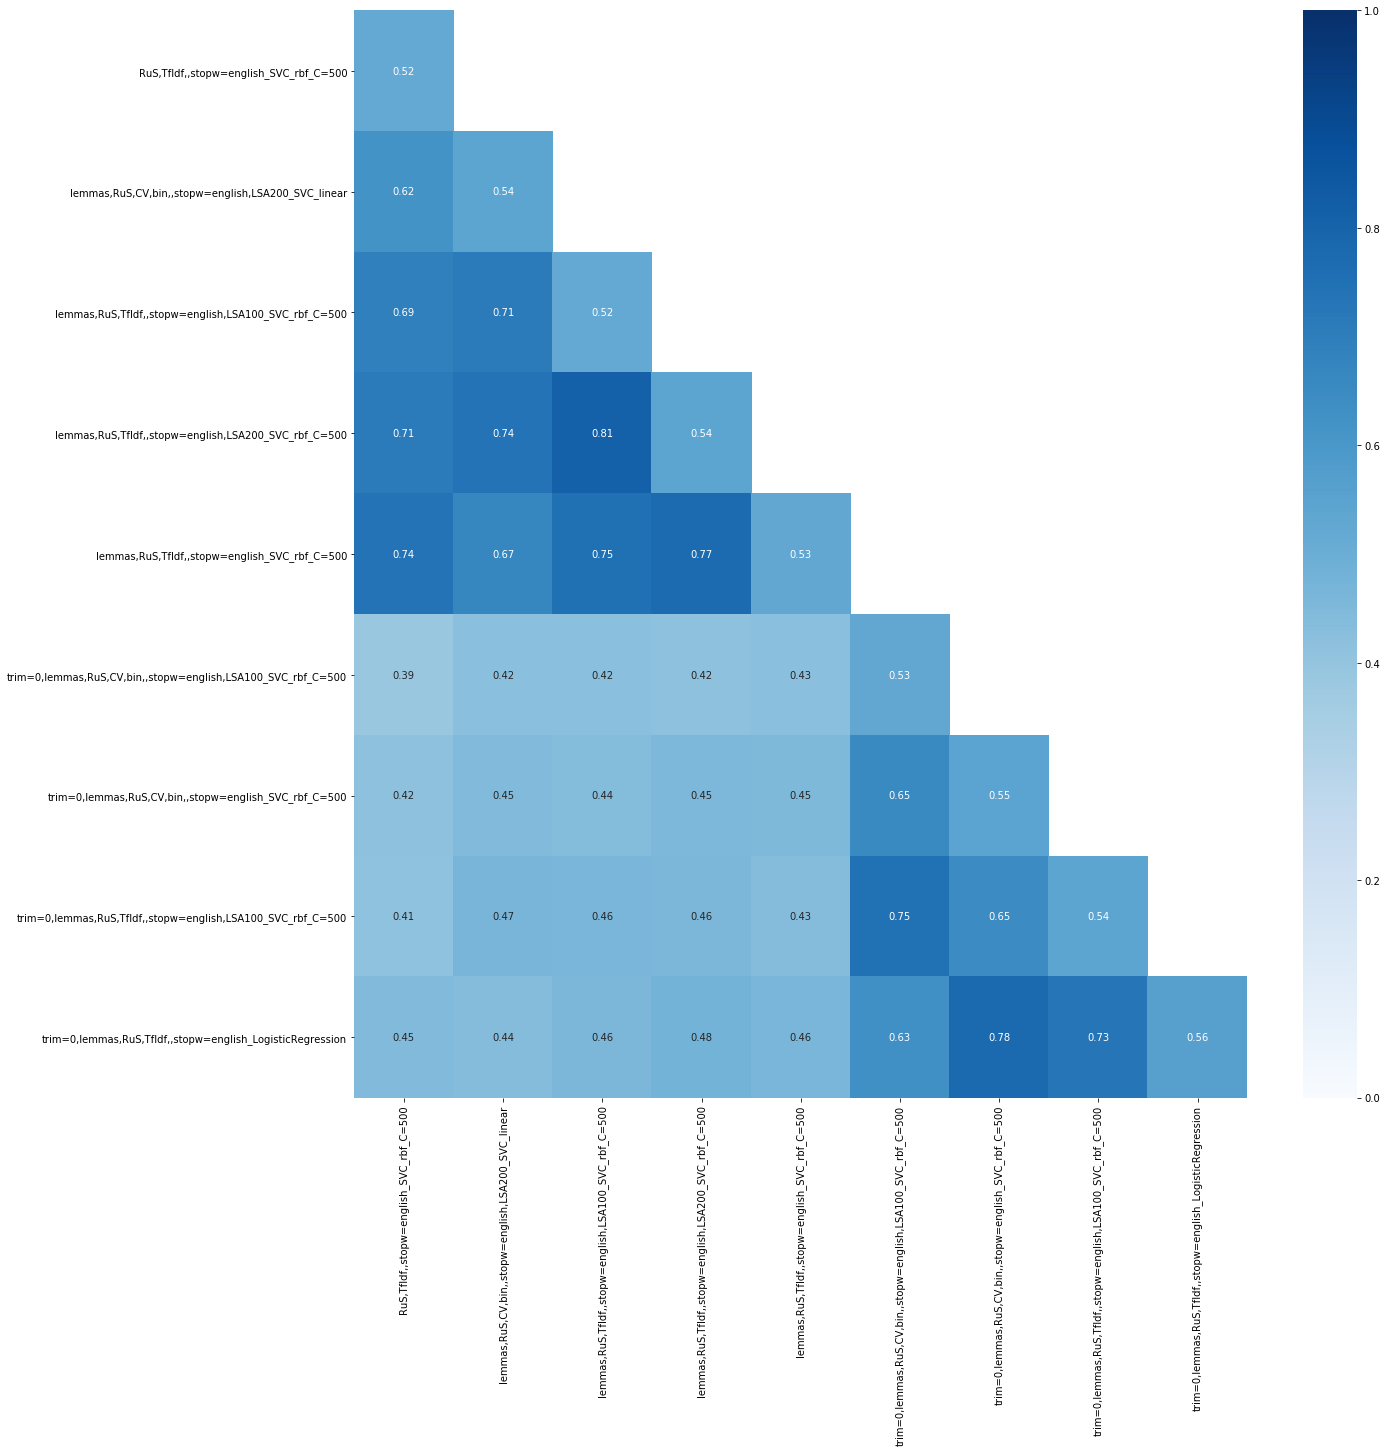

In [36]:
diversity_heatmap(results_dict, figsize=(20,20), )

In [38]:
results_dict.keys()

['lemmas,RuS,CV,bin,,stopw=english,LSA200_SVC_linear',
 'lemmas,RuS,TfIdf,,stopw=english,LSA100_SVC_rbf_C=500',
 'trim=0,lemmas,RuS,TfIdf,,stopw=english_LogisticRegression',
 'trim=0,lemmas,RuS,CV,bin,,stopw=english_SVC_rbf_C=500',
 'trim=0,lemmas,RuS,TfIdf,,stopw=english,LSA100_SVC_rbf_C=500',
 'lemmas,RuS,TfIdf,,stopw=english_SVC_rbf_C=500',
 'lemmas,RuS,TfIdf,,stopw=english,LSA200_SVC_rbf_C=500',
 'RuS,TfIdf,,stopw=english_SVC_rbf_C=500',
 'trim=0,lemmas,RuS,CV,bin,,stopw=english,LSA100_SVC_rbf_C=500']

In [66]:
# create functions out of dictionaries

threshold = 0.5

funcs = [lambda c: 1 if results_dict[model]['label_unlab_prob_dict'][c.id]>threshold else -1 \
                             for model in results_dict.keys() ]
funcs_names = [model for model in results_dict.keys() ]

In [86]:
results_dict[results_dict.keys()[3]].keys()

['label_unlab_binary',
 'label_val_prob_dict',
 'label_unlab_prob_dict',
 'f1+',
 'label_val_binary',
 'label_test_prob_dict',
 'classification_report',
 'label_test_binary']

In [83]:
results_dict['trim=0,lemmas,RuS,CV,bin,,stopw=english_SVC_rbf_C=500']['label_unlab_prob_dict'][c.id]>threshold

True

In [88]:
def signal_annotator(c):
    """A generator over the different (worker_id, label_id) pairs for a Tweet."""
    for model in results_dict.keys():
        yield model, results_dict[model]['label_unlab_binary']

labeler = LabelAnnotator(label_generator=signal_annotator)

# Put them into the model as pipelines

In [18]:
def predictions_exist_for(c):
    """For now, skip unmapped candidates in the test set - as no predictions where generated for them."""
    if c.id in results_dict[results_dict.keys()[0]]['label_prob_dict'].keys():
        return True
    else:
        return False

In [19]:
# Pass classifier output as signals


def LogisticRegression(c):
    if predictions_exist_for(c):
        return -1 if results_dict['LogisticRegression']['label_prob_dict'][c.id]>threshold else 1
    else:
        return 0
        
def SVC_rbf_C500(c):
    if predictions_exist_for(c):
        return -1 if results_dict['SVC_rbf_C=500']['label_prob_dict'][c.id]>threshold else 1
    else:
        return 0
    
def SVC_rbf_C100(c):
    if predictions_exist_for(c):
        return -1 if results_dict['SVC_rbf_C=100']['label_prob_dict'][c.id]>threshold else 1
    else:
        return 0
    
def SVC_rbf_C1000(c):
    if predictions_exist_for(c):
        return -1 if results_dict['SVC_rbf_C=1000']['label_prob_dict'][c.id]>threshold else 1
    else:
        return 0

def SVC_linear(c):
    if predictions_exist_for(c):
        return -1 if results_dict['SVC_linear']['label_prob_dict'][c.id]>threshold else 1
    else:
        return 0
    

In [21]:
LFs = [
    dummy,
    LogisticRegression,
    SVC_linear,
    SVC_rbf_C100,
    SVC_rbf_C500,
    SVC_rbf_C1000
]


In [11]:
min(results_dict['SVC_rbf_C=1000']['label_prob_dict'].keys())

24808

In [72]:
funcs_names

['lemmas,RuS,CV,bin,,stopw=english,LSA200_SVC_linear',
 'lemmas,RuS,TfIdf,,stopw=english,LSA100_SVC_rbf_C=500',
 'trim=0,lemmas,RuS,TfIdf,,stopw=english_LogisticRegression',
 'trim=0,lemmas,RuS,CV,bin,,stopw=english_SVC_rbf_C=500',
 'trim=0,lemmas,RuS,TfIdf,,stopw=english,LSA100_SVC_rbf_C=500',
 'lemmas,RuS,TfIdf,,stopw=english_SVC_rbf_C=500',
 'lemmas,RuS,TfIdf,,stopw=english,LSA200_SVC_rbf_C=500',
 'RuS,TfIdf,,stopw=english_SVC_rbf_C=500',
 'trim=0,lemmas,RuS,CV,bin,,stopw=english,LSA100_SVC_rbf_C=500']

In [78]:
# labels = lambda c : [(lf.__name__, lf(c)) for lf in lfs]

In [69]:
# some predictions are missing because the labels are not mapped - hence cands were not exported in sklearn.
# TODO: possible fixes: 
# a) export all missing label candidates - will be the case when denoising with unlab set 
# b) abstain from voting if missing values - makes more sense
# ^^ b shouldnt be a problem when a is fixed

for c in session.query(REGULATOR).filter(REGULATOR.split == 3)[30:50]:
    print c.id, c.gold_labels, " | Predictions: ", funcs[1](c), funcs[2](c), funcs[0](c), funcs[3](c)
    print 
    

40006 []  | Predictions:  1 1 1 1
40007 []  | Predictions:  1 1 1 1
40008 []  | Predictions:  1 1 1 1
40009 []  | Predictions:  1 1 1 1
40010 []  | Predictions:  -1 -1 -1 -1
40011 []  | Predictions:  -1 -1 -1 -1
40012 []  | Predictions:  -1 -1 -1 -1
40013 []  | Predictions:  -1 -1 -1 -1
40014 []  | Predictions:  -1 -1 -1 -1
40015 []  | Predictions:  -1 -1 -1 -1
40016 []  | Predictions:  -1 -1 -1 -1
40017 []  | Predictions:  1 1 1 1
40018 []  | Predictions:  1 1 1 1
40019 []  | Predictions:  -1 -1 -1 -1
40020 []  | Predictions:  1 1 1 1
40021 []  | Predictions:  1 1 1 1
40022 []  | Predictions:  1 1 1 1
40023 []  | Predictions:  1 1 1 1
40024 []  | Predictions:  1 1 1 1
40025 []  | Predictions:  1 1 1 1


# Train the generative model (denoise)

In [79]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=LFs)

NameError: name 'LFs' is not defined

In [29]:
%time L_train = labeler.apply(split=2)
L_train

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 30.1 s, sys: 28 ms, total: 30.2 s
Wall time: 30.2 s


<13350x6 sparse matrix of type '<type 'numpy.int64'>'
	with 42255 stored elements in Compressed Sparse Row format>

In [30]:
# see how many LF vote on how many examples & with how many other LFs there are votes on common examples
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
dummy,0,1.000000,0.433034,0.128764
LogisticRegression,1,0.433034,0.433034,0.128764
SVC_linear,2,0.433034,0.433034,0.128764
SVC_rbf_C100,3,0.433034,0.433034,0.128764
SVC_rbf_C500,4,0.433034,0.433034,0.128764
SVC_rbf_C1000,5,0.433034,0.433034,0.128764


In [35]:
# Find dependencies between LFs

from snorkel.learning.structure import DependencySelector
ds = DependencySelector()
deps = ds.select(L_train, threshold=0.1)
len(deps)

10

In [36]:
# actual training of the gen. model
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel(lf_propensity=True)
gen_model.train(
    L_train, deps=deps, decay=0.95, step_size=0.1/L_train.shape[0], reg_param=0.0
)

Inferred cardinality: 2


In [37]:
train_marginals = gen_model.marginals(L_train)

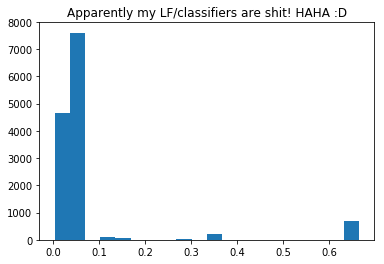

In [41]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.title('Apparently my LF/classifiers are shit! HAHA :D')
plt.show()

In [45]:

print 'But it still thinks its smart!!!! \nLOOK:'
gen_model.learned_lf_stats()

But it still thinks its smart!!!! 
LOOK:


,Accuracy,Coverage,Precision,Recall
0,0.938522,0.8442,0.943077,0.795390
1,0.887379,0.4120,0.895081,0.391694
2,0.890816,0.4094,0.898513,0.391313
3,0.891793,0.4094,0.902546,0.391694
4,0.893437,0.4129,0.898838,0.397790
5,0.898780,0.4100,0.905341,0.397219


In [46]:
# save probabilistic labels for the LSTM  -  this is the # of train. examples our LSTM will train on
from snorkel.annotations import save_marginals
save_marginals(session, L_train, train_marginals)

Saved 13350 marginals


In [47]:
L_test = labeler.apply_existing(split=2)

Clearing existing...
Running UDF...
[========================================] 100%



In [49]:
# load from db gold labels
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)
L_gold_test

<13350x1 sparse matrix of type '<type 'numpy.int64'>'
	with 5781 stored elements in Compressed Sparse Row format>

In [50]:
_ = gen_model.error_analysis(session, L_test, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.259
Neg. class accuracy: 0.975
Precision            0.57
Recall               0.259
F1                   0.356
----------------------------------------
TP: 388 | FP: 293 | TN: 11557 | FN: 1112



In [51]:
L_test.lf_stats(session, L_gold_test, gen_model.learned_lf_stats()['Accuracy'])

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
dummy,0,1.000000,0.433034,0.128764,0,0,1500,4281,0.740529,0.936173
LogisticRegression,1,0.433034,0.433034,0.128764,683,563,817,3718,0.761287,0.893057
SVC_linear,2,0.433034,0.433034,0.128764,594,592,906,3689,0.740875,0.888321
SVC_rbf_C100,3,0.433034,0.433034,0.128764,606,500,894,3781,0.758865,0.893826
SVC_rbf_C500,4,0.433034,0.433034,0.128764,625,484,875,3797,0.764920,0.897841
SVC_rbf_C1000,5,0.433034,0.433034,0.128764,577,480,923,3801,0.757308,0.899282
